In [1]:
source("./utils.R")

here() starts at /home/gridsan/tdn/replicate-papers/covid-infections/SARS-CoV-2-VL-paper

This is cmdstanr version 0.6.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/gridsan/tdn/.cmdstan/cmdstan-2.33.1

- CmdStan version: 2.33.1

This is posterior version 1.5.0


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:posterior’:

    rhat



Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


Loading required package: R.oo

Loading req

In [30]:
library(brms)
library(dplyr)
library(ggdist)
library(rstan)
library(cmdstanr)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Analysis 2.3 from ExtendedMethods.html

In [3]:
dirname <- "B117fits"
if (!dir.exists(dirname)) {
  dir.create(dirname)
}

## get data


In [14]:
bdata = 
  get_log10Load_data() %>%
  .[, PCR_Gender_Group := factor(paste0(PCR,"_",Gender,"_",Group))] %>%
  .[, PCR_Group := factor(paste0(PCR,"_",Group))] %>%
  .[, fAgeGroup := factor(AgeGroup, ordered = F)] %>% 
  .[, Male := ifelse(Gender == "M",1,ifelse(Gender == "F",0,.5))]

bdata.B117 = 
  bdata %>%
  .[, B117 := factor(B117, labels = c("non-B117","B117"))] %>% 
  .[, Sex := ifelse(Gender == "U",.5,ifelse(Gender == "M",1,0))]

B117data = 
  bdata.B117 %>%
  .[B117CentreDay1 == 1]
### with adjustment, non-B117 & B117 in centre ####
CentresWithMin2Cases = 
  B117data[,.(N = .N), by = .(TestCentre)][N > 1,TestCentre]
B117data = 
  B117data[TestCentre %in% CentresWithMin2Cases]
print(dim(B117data))

[1] 2428   39


## save data to disk

In [58]:
write.csv(B117data, 
          file = "B117data.csv",
          row.names = FALSE)

## define formula

In [15]:
B117model.re.adjusted =
  bf(log10Load ~ B117 + Group + Sex + PCR + s(Age) + (1 | TestCentre),
     sigma ~ B117 + PAMS + (1 | TestCentre))

## make stancode

In [16]:
scode <- make_stancode(B117model.re.adjusted, data = B117data)
spath <- write_stan_file(scode)
cat(scode)

// generated with brms 2.20.4
functions {
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int<lower=1> Kc;  // number of population-level effects after centering
  // data for splines
  int Ks;  // number of linear effects
  matrix[N, Ks] Xs;  // design matrix for the linear effects
  // data for spline 1
  int nb_1;  // number of bases
  array[nb_1] int knots_1;  // number of knots
  // basis function matrices
  matrix[N, knots_1[1]] Zs_1_1;
  int<lower=1> K_sigma;  // number of population-level effects
  matrix[N, K_sigma] X_sigma;  // population-level design matrix
  int<lower=1> Kc_sigma;  // number of population-level effects after centering
  // data for group-level effects of ID 1
  int<lower=1> N_1;  // number of grouping levels
  int<lower=1> M_1;  // number of coefficients per level
  array[N] int<lower=1> J_1;  // gr

## make standata

In [17]:
sdata <- make_standata(B117model.re.adjusted, data = B117data)

The B117B117 column is part of sdata$X. Based on the column names, we guess that in the original data, B117 is a factor variable with two levels, one being B117. Based on the stancode (see the transformed data block), b_B117B117 in the equivalent brm() fit is the first entry of the coefficient vector b in a cmdstanr fit.

In [18]:
head(sdata$X) 

,Intercept,B117B117,GroupPAMS,GroupHospitalized,Sex,PCRLC480
1,1,1,0,0,0,0
2,1,0,0,0,1,0
3,1,1,0,0,1,0
4,1,0,1,0,1,0
5,1,1,0,0,1,0
6,1,1,0,1,1,0


Number of linear terms including intercept

In [19]:
sdata$K

[1] 6

Number of linear terms discarding intercept

In [20]:
sdata$Kc

[1] 5

## fit model

### brms
Takes about 6 minutes to draw samples.

In [22]:
Bfit <- brm(formula = B117model.re.adjusted, 
            data = B117data,
            backend = "cmdstanr",
            iter = 3500,
            chains = 4,
            cores = 4,
            warmup = 1000,
            refresh = 0,
            control = list(adapt_delta = 0.99))

Start sampling

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/state/partition1/slurm_tmp/24347863.0.0/Rtmp5TQ9fY/model-371fbd27208d77.stan', line 102, column 4 to column 41)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/state/partition1/slurm_tmp/24347863.0.0/Rtmp5TQ9fY/model-371fbd27208d77.stan', line 102, column 4 to column 41)

Chain 3 If this warning occurs sporadically, such as for highly constraine

### cmdstanr

In [23]:
mod <- cmdstan_model(spath)
cmdstanfit <- mod$sample(data = sdata,
                         chains = 4,
                         parallel_chains = 4,
                         iter_warmup  = 1000,
                         iter_sampling = 2500,
                         refresh = 0,
                         adapt_delta = 0.99)

Running MCMC with 4 parallel chains...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/state/partition1/slurm_tmp/24347863.0.0/Rtmp5TQ9fY/model-371fbd34bd1bc9.stan', line 101, column 4 to column 41)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/state/partition1/slurm_tmp/24347863.0.0/Rtmp5TQ9fY/model-371fbd34bd1bc9.stan', line 101, column 4 to column 41)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable type

Chain 4 finished in 244.4 seconds.
Chain 1 finished in 250.3 seconds.
Chain 2 finished in 254.4 seconds.
Chain 3 finished in 382.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 283.0 seconds.
Total execution time: 382.9 seconds.



See https://mc-stan.org/misc/warnings for details.




### check that b[1] in cmdstanr fit is the ``same'' as b_B117B117 in brms fit

In [26]:
get_B117_stats(Bfit,"RE, adjusted, (paired)",1,"Yes")

Window,Model,N B.1.1.7,N non-B.1.1.7,Load B.1.1.7,Load non-B.1.1.7,Effect B.1.1.7
<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,"RE, adjusted, (paired)",1451,977,"7.2 (7.1, 7.4)","6.2 (6.0, 6.4)","1.04 (0.92, 1.15)"


In [57]:
cmdstanfit$draws(format = "draws_df") %>% dplyr::pull(as.name("b[1]")) %>% quantile(probs = c(0.05, 0.95))
cmdstanfit$draws(format = "draws_df") %>% dplyr::pull(as.name("b[1]")) %>% mean()

5%       95% 
0.9204093 1.1533915

[1] 1.03641

## plot rhat

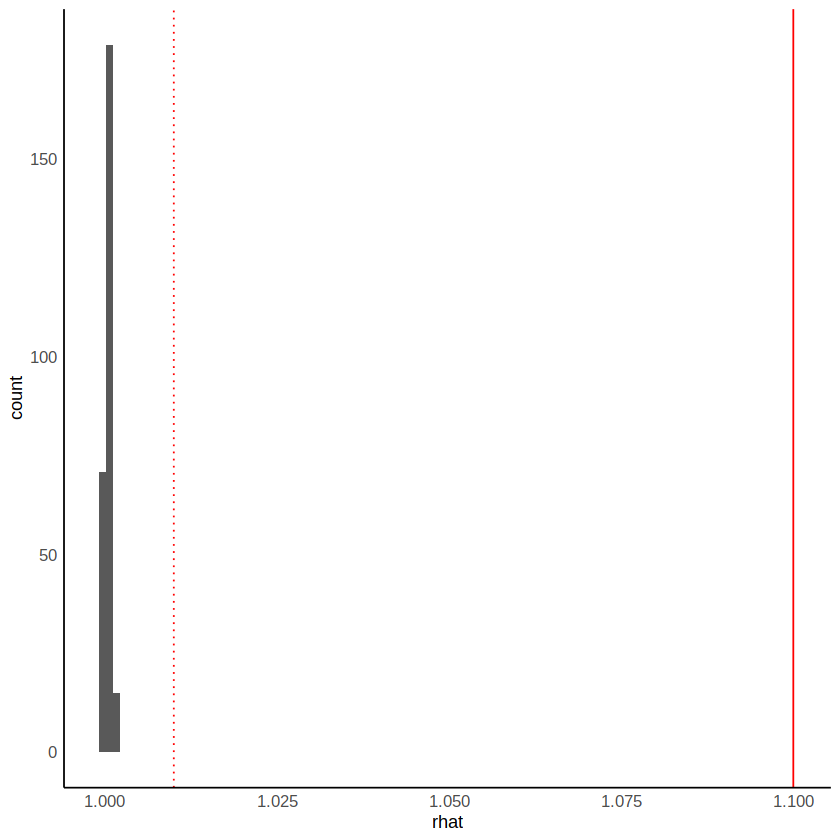

In [34]:
B117_model_stats = get_B117_stats(Bfit,"RE, adjusted, (paired)",1,"Yes")
data.table(rhat = rhat(Bfit)) %>% 
  ggplot(aes(x = rhat)) + 
  geom_histogram(bins = 100) + 
  geom_vline(xintercept = 1.1, color = "red")+ 
  geom_vline(xintercept = 1.01, color = "red", lty = 3)

B117fit = Bfit
saveRDS(B117fit, file.path(dirname, "B117fit.RData"))

In [35]:
class(Bfit)

[1] "brmsfit"

In [36]:
methods(class="brmsfit")

 [1] add_criterion           add_ic                  as_draws_array         
 [4] as_draws_df             as_draws_list           as_draws_matrix        
 [7] as_draws_rvars          as_draws                as.array               
[10] as.data.frame           as.matrix               as.mcmc                
[13] autocor                 bayes_factor            bayes_R2               
[16] bridge_sampler          coef                    conditional_effects    
[19] conditional_smooths     control_params          expose_functions       
[22] family                  fitted                  fixef                  
[25] formula                 getCall                 hypothesis             
[28] kfold                   launch_shinystan        log_lik                
[31] log_posterior           logLik                  loo_compare            
[34] loo_linpred             loo_model_weights       loo_moment_match       
[37] loo_predict             loo_predictive_interval loo_R2                 

In [37]:
cat(stancode(Bfit))

// generated with brms 2.20.4
functions {
  
}
data {
  int<lower=1> N; // total number of observations
  vector[N] Y; // response variable
  int<lower=1> K; // number of population-level effects
  matrix[N, K] X; // population-level design matrix
  int<lower=1> Kc; // number of population-level effects after centering
  // data for splines
  int Ks; // number of linear effects
  matrix[N, Ks] Xs; // design matrix for the linear effects
  // data for spline 1
  int nb_1; // number of bases
  array[nb_1] int knots_1; // number of knots
  // basis function matrices
  matrix[N, knots_1[1]] Zs_1_1;
  int<lower=1> K_sigma; // number of population-level effects
  matrix[N, K_sigma] X_sigma; // population-level design matrix
  int<lower=1> Kc_sigma; // number of population-level effects after centering
  // data for group-level effects of ID 1
  int<lower=1> N_1; // number of grouping levels
  int<lower=1> M_1; // number of coefficients per level
  array[N] int<lower=1> J_1; // grouping indic

# Results 3.2 from ExtendedMethods.html 

## Read fit from disk

In [38]:
B117fit <- readRDS(file.path(dirname, "B117fit.RData"))

In [39]:
B117fit$fit %>% 
  as_draws() %>% 
  head()

# A draws_array: 6 iterations, 4 chains, and 265 variables
, , variable = b_Intercept

         chain
iteration   1   2   3   4
        1 6.1 6.0 6.1 6.3
        2 6.1 6.1 6.2 6.2
        3 6.2 6.0 5.9 6.2
        4 6.2 6.0 6.1 6.0
        5 6.2 6.3 6.3 5.9

, , variable = b_sigma_Intercept

         chain
iteration    1    2    3    4
        1 0.62 0.55 0.51 0.54
        2 0.58 0.53 0.55 0.53
        3 0.60 0.63 0.62 0.53
        4 0.58 0.53 0.52 0.59
        5 0.57 0.54 0.50 0.57

, , variable = b_B117B117

         chain
iteration    1    2    3    4
        1 1.11 0.94 1.03 1.06
        2 1.08 1.04 1.08 1.01
        3 0.96 1.04 1.04 0.96
        4 0.97 1.11 1.01 1.11
        5 1.13 0.96 0.96 1.09

, , variable = b_GroupPAMS

         chain
iteration    1    2     3      4
        1 0.59 0.66 0.257 -0.183
        2 0.59 0.55 0.114  0.064
        3 0.41 0.31 0.465  0.433
        4 0.47 0.34 0.443  0.167
        5 0.22 0.43 0.085  0.581

# ... with 1 more iterations, and 261 more var

## Create data frames

In [40]:
B117.draws = 
  as_draws(B117fit$fit) %>% 
  subset_draws(c("b_Intercept","b_B117B117")) %>% 
  as_draws_dt() %>% 
  setkeyv(".draw") %>% 
  .[, `:=` (
    load.nonB117 = b_Intercept,
    load.B117 = b_Intercept + b_B117B117)] %>% 
  .[, .(.draw, load.nonB117, load.B117)] %>% 
  .[, `:=`(load.deltaB117 = load.B117 - load.nonB117)] %>% 
  melt(id.vars = ".draw") %>% 
  .[, B117 := ifelse(grepl("RR",variable),"RRB117",
                     ifelse(grepl("delta",variable),"deltaB117",
                            ifelse(grepl("nonB117",variable),"nonB117","B117")))] %>% 
  .[, Outcome := "log10Load"]

In [41]:
B117.draws %>% head()

.draw,variable,value,B117,Outcome
<int>,<fct>,<dbl>,<chr>,<chr>
1,load.nonB117,6.05183,nonB117,log10Load
2,load.nonB117,6.06887,nonB117,log10Load
3,load.nonB117,6.19392,nonB117,log10Load
4,load.nonB117,6.18991,nonB117,log10Load
5,load.nonB117,6.18701,nonB117,log10Load
6,load.nonB117,6.09610,nonB117,log10Load


## Plot

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


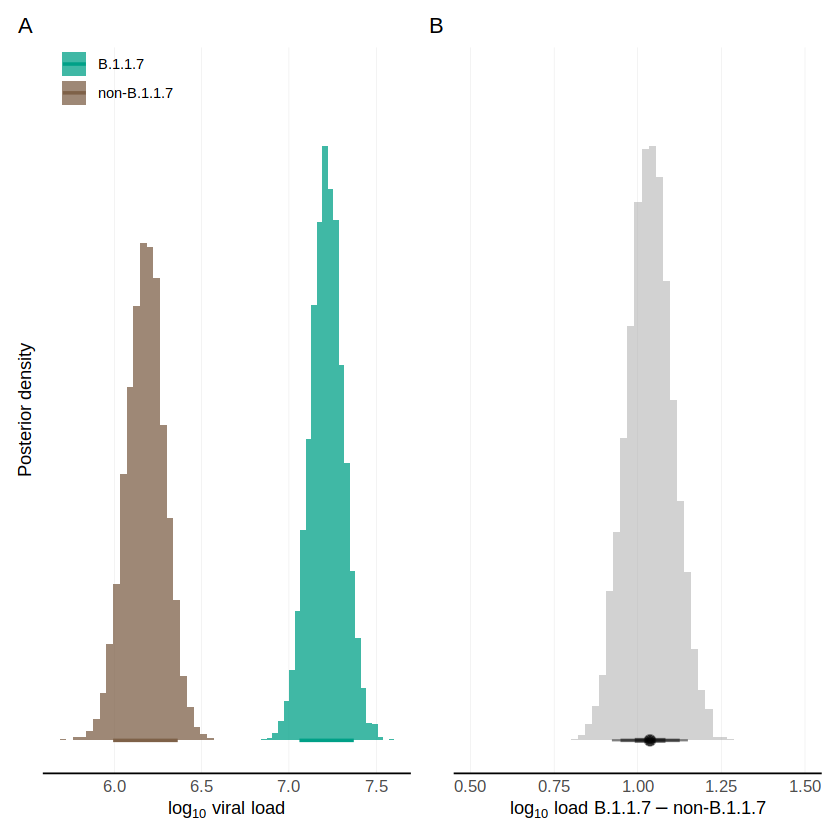

In [42]:
no_y_axis = theme(axis.title.y = element_blank(), axis.line.y = element_blank(), axis.text.y = element_blank())

p1 = 
  B117.draws[Outcome == "log10Load" & !(grepl("delta|RR",B117))] %>% 
  ggplot(aes(x = value, fill = B117)) +
  stat_histinterval(.width = c(.50, .80, .90), breaks = 25, alpha = .75, color = NA) + 
  scale_fill_manual(values = c("#00A087FF","#7E6148FF"),
                    name = "", labels = c("B.1.1.7","non-B.1.1.7")) +
  scale_color_manual(values = c("#00A087FF","#7E6148FF"),
                    name = "", labels = c("B.1.1.7","non-B.1.1.7")) +
  theme(axis.line.y = element_blank(), axis.text.y = element_blank()) +
  xlab(expression(log[10]~viral~load)) + 
  theme(legend.position = c(.2,.975)) + 
  ylab("Posterior density")

hdi.data = rbind(
  B117.draws[variable == "load.B117",value] %>% 
  fast.hdi(posterior.dist = "norm") %>% 
  .[,.(lower90,upper90)] %>% 
  .[, hdi.group := 1] %>% 
  melt(id.vars = "hdi.group") %>% 
  .[, B117 := "B117"] %>% 
  .[, y := 0],
  B117.draws[variable == "load.nonB117",value] %>% 
  fast.hdi(posterior.dist = "norm") %>% 
  .[,.(lower90,upper90)] %>% 
  .[, hdi.group := 1] %>% 
  melt(id.vars = "hdi.group") %>% 
  .[, B117 := "nonB117"] %>% 
  .[, y := 0])

p1 = 
  p1 +
  geom_line(data = hdi.data,
            aes(y = y, x = value, group = interaction(hdi.group,B117), color = B117),
            size = 1) + 
  gg_add_grid("x")

p2 = 
  B117.draws[Outcome == "log10Load" & (grepl("delta",B117))] %>% 
  ggplot(aes(x = value)) +
  stat_histinterval(.width = c(.50, .80, .90), breaks = 25, alpha = .5) + 
  theme(axis.line.y = element_blank(), axis.text.y = element_blank()) +
  xlab(expression(log[10]~load~B.1.1.7-`non-B.1.1.7`)) +
  coord_cartesian(xlim= c(0.5,1.5)) +
  ylab("") + 
  gg_add_grid("x")

pB117load = (p1 + ggtitle("A")| p2 + ggtitle("B")) + plot_layout(widths = c(1,1))


pB117load